In [3]:
using Turing, Distributions, DifferentialEquations, KernelDensity
using MCMCChains,CSV,DataFrames,StatsBase
#using StatsPlots,,PairPlots,Plots
using PyPlot
PyPlot.svg(true)
using LaTeXStrings
include("./functions.jl")

inference_pipeline (generic function with 1 method)

In [4]:
θ = (σ=0.01,α = 0.003*60, β = 0.001*60,ρ=  0.006*60,τ = 5.)
u0 = [1.0,0.0,0.0]
prob = ODEProblem(mbr_model,u0,(0.0,12.0),[p for p in θ])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 12.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0

# Test on correct model

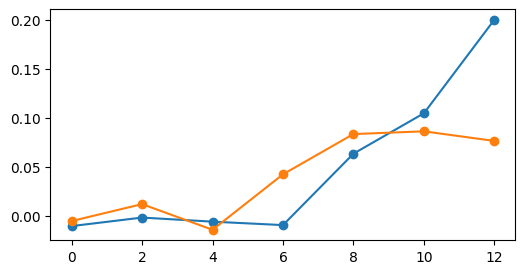

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc1fc36ea30>

In [5]:
θ = (σ=0.01,α = 0.003*60, β = 0.001*60,ρ=  0.006*60,τ = 5.)
u0 = [100.0,0.0,0.0]
prob = ODEProblem(mbr_model,u0,(0.0,12.0),[p for p in θ])
sol = solve(prob,Tsit5(),saveat=collect(0:2.:12));
u_obs = [u for u in sol.u]
syn_data = DataFrame(:time=>sol.t,
    :gfp=>[u[3] / sum(u) + rand(Normal(0,θ[1])) for u in u_obs],
    :dsb=>[u[2] / sum(u) + rand(Normal(0,θ[1])) for u in u_obs])

fig,ax = plt.subplots(figsize=(6,3))
ax.plot(syn_data.time,syn_data.gfp,"o-")
ax.plot(syn_data.time,syn_data.dsb,"o-")


In [6]:
chain = get_posterior(syn_data)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:33
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


143.569703 seconds (725.87 M allocations: 53.283 GiB, 5.76% gc time, 0.10% compilation time)


Chains MCMC chain (500×17×3 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 3
Samples per chain = 500
Wall duration     = 121.3 seconds
Compute duration  = 118.05 seconds
parameters        = α, ρ, σ, τ, β
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ    0.0119    0.0029     0.0001    0.0002   282.3611    1.0189     ⋯
           α    0.2318    0.1929     0.0050    0.0250    44.9647    1.0249     ⋯
           β    0.0605    0.0149     0.0004    0.0020    42.5289    1.0315     ⋯
           ρ    0.3684    0.0393     0.0010    0.0030   148.6908    1.0041     ⋯
           τ    4.5698    0.3411     0.0088    0.0310    93.4

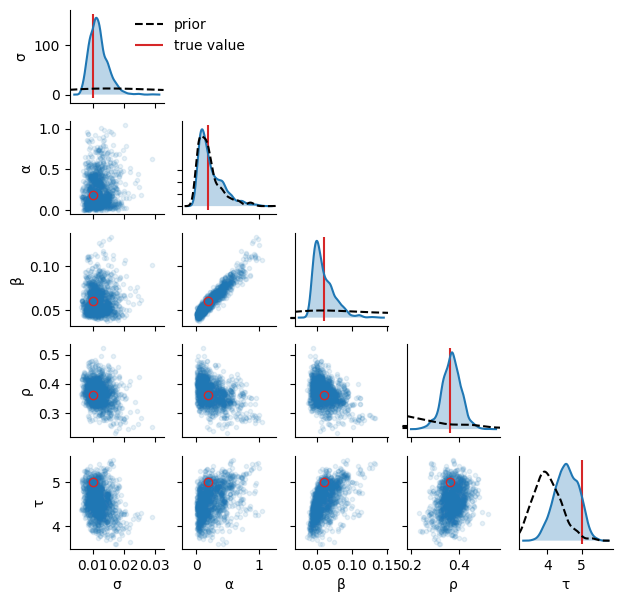

In [7]:
chain_df = DataFrame(chain)[:,[:σ,:α,:β,:ρ,:τ]]
axs = posterior_corner(chain_df,(7,7))
for j in 1:5
    y_min, y_max = axs[j,j].get_ylim()
    axs[j,j].vlines([θ[j]],y_min, y_max,color="C3",label="true value")
    x_min, x_max = axs[j,j].get_xlim()
    U = kde(rand(priors[j],200))
    axs[j,j].plot(U.x,U.density,"k--",label = "prior")
    axs[j,j].set_xlim(x_min,x_max)
    axs[1,1].legend(frameon=false,loc = "upper right", bbox_to_anchor=(2, 1.05))
    for i in j+1:5
        axs[i,j].plot([θ[j]],[θ[i]],"C3o",fillstyle="none")
    end
end
plt.savefig("/home/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/DNA repair/Supplementary_bayes-test1.png")

# Non-gaussian errors

In [8]:
sol.u

7-element Vector{Vector{Float64}}:
 [100.0, 0.0, 0.0]
 [100.0, 0.0, 0.0]
 [100.0, 0.0, 0.0]
 [112.74821229003624, 5.372230657543723, 1.0659649526798272]
 [143.3310699792991, 13.671288340936927, 9.729981668669327]
 [182.2094972890301, 20.709901191700983, 28.69070352754621]
 [231.63367190051488, 27.948408723840647, 61.96877140658494]

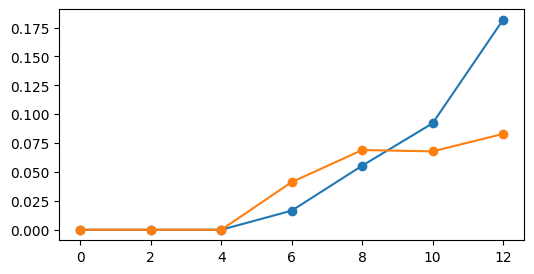

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc1767fea90>

In [9]:
θ = (σ=0.01,α = 0.003*60, β = 0.001*60,ρ=  0.006*60,τ = 5.)
u0 = [100.0,0.0,0.0]
prob = ODEProblem(mbr_model,u0,(0.0,12.0),[p for p in θ])
sol = solve(prob,Tsit5(),saveat=collect(0:2.:12));
u_obs = [u .+  sqrt.(u).*rand(Normal(0,1),3) for u in sol.u]
syn_data = DataFrame(:time=>sol.t,
    :gfp=>[u[3] / sum(u) for u in u_obs],
    :dsb=>[u[2] / sum(u) for u in u_obs])

fig,ax = plt.subplots(figsize=(6,3))
ax.plot(syn_data.time,syn_data.gfp,"o-")
ax.plot(syn_data.time,syn_data.dsb,"o-")

In [10]:
chain = get_posterior(syn_data)

chain_df = DataFrame(chain)[:,[:α,:β,:ρ,:τ]]
axs = posterior_corner(chain_df,(7,7))
for j in 1:4
    y_min, y_max = axs[j,j].get_ylim()
    axs[j,j].vlines([θ[j+1]],y_min, y_max,color="C3",label="true value")
    x_min, x_max = axs[j,j].get_xlim()
    U = kde(rand(priors[j+1],200))
    axs[j,j].plot(U.x,U.density,"k--",label = "prior")
    axs[j,j].set_xlim(x_min,x_max)
    axs[1,1].legend(frameon=false,loc = "upper right", bbox_to_anchor=(2, 1.05))
    for i in j+1:4
        axs[i,j].plot([θ[j+1]],[θ[i+1]],"C3o",fillstyle="none")
    end
end
plt.savefig("/home/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/DNA repair/Supplementary_bayes-test2.png")

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:56
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:56
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:55


168.513220 seconds (868.60 M allocations: 57.366 GiB, 5.00% gc time)


# Hidden state

In [11]:
θ = (σ=0.01,α = 0.003*60, β = 0.001*60,\gamma ρ=  0.006*60,τ = 5.)
u0 = [100.0,0.0,0.0]
prob = ODEProblem(mbr_model,u0,(0.0,12.0),[p for p in θ])
sol = solve(prob,Tsit5(),saveat=collect(0:2.:12));
u_obs = [u for u in sol.u]
syn_data = DataFrame(:time=>sol.t,
    :gfp=>[u[3] / sum(u) + rand(Normal(0,θ[1])) for u in u_obs],
    :dsb=>[u[2] / sum(u) + rand(Normal(0,θ[1])) for u in u_obs])

fig,ax = plt.subplots(figsize=(6,3))
ax.plot(syn_data.time,syn_data.gfp,"o-")
ax.plot(syn_data.time,syn_data.dsb,"o-")

LoadError: syntax: "\" is not a unary operator